# Prudentia WebRTC Extension (p1)

## Google Meets: Some 1:1 QoS Analytics Using TCPDump

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import re
from datetime import datetime, timedelta

In [2]:
blue = sns.color_palette('muted')[0]
orange = sns.color_palette('muted')[1]
green = sns.color_palette('muted')[2]

In [3]:
plt.rc('figure', figsize=(10, 6))
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=18)
plt.rc('font', size=14)

In [4]:
file_path = "google_meetings_ana"

timestamps = []
lengths = []

pattern = r'(\d{2}:\d{2}:\d{2}\.\d+) .* length (\d+)'

i = 0
with open(file_path, "r") as file:
    for line in file:
        line = line.strip()
        match = re.search(pattern, line)
        if match:
            timestamp_str = match.group(1)
            length = int(match.group(2))
            timestamp = datetime.strptime(timestamp_str, "%H:%M:%S.%f")
            timestamps.append(timestamp)
            lengths.append(length)

x = timestamps[0:(len(timestamps)//3)]
y = lengths[0:(len(lengths)//3)]

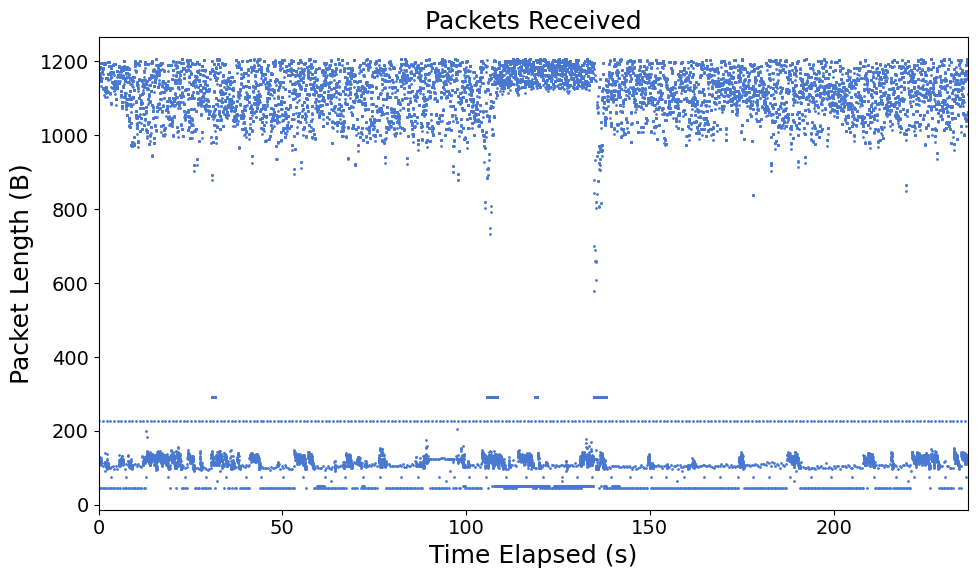

In [15]:
fig, ax = plt.subplots()
elapsed = [(e - x[0]).total_seconds() for e in x]

ax.scatter(elapsed, y, color=blue, s=1)
ax.set_title("Packets Received")
ax.set_xlabel("Time Elapsed (s)")
ax.set_ylabel("Packet Length (B)")

plt.xlim(0, elapsed[-1])
plt.tight_layout()
plt.show()

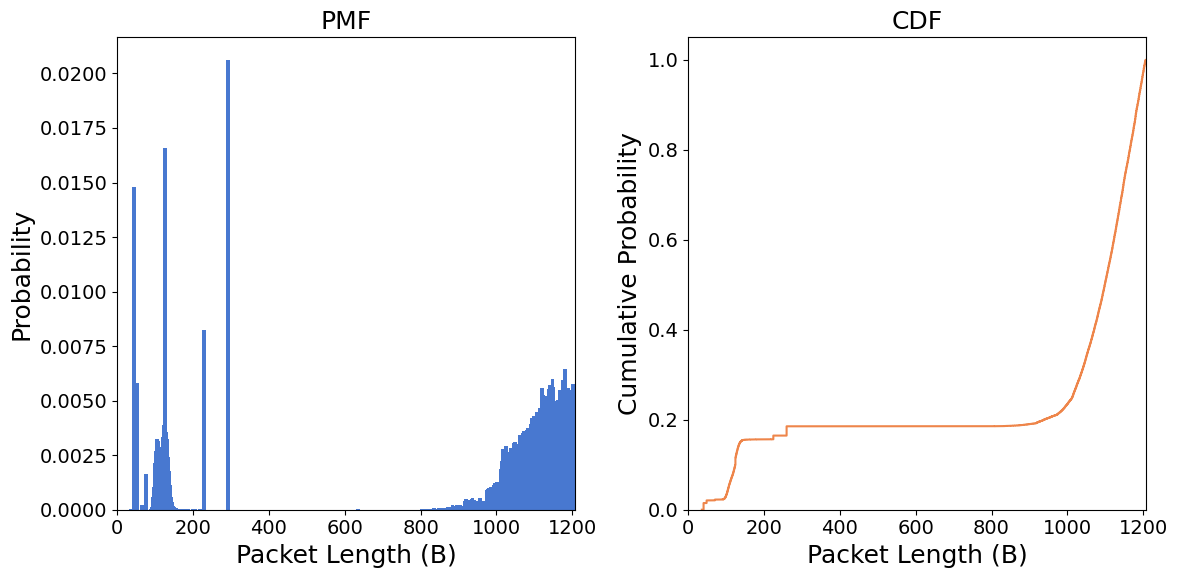

In [31]:
unique_lengths, counts = np.unique(lengths, return_counts=True)
pmf = counts / len(lengths)

sorted_lengths = np.sort(unique_lengths)
cdf = np.cumsum(pmf)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(unique_lengths, pmf, width=10, color=blue)
plt.title("PMF")
plt.xlabel("Packet Length (B)")
plt.ylabel("Probability")
plt.xlim(0, unique_lengths[-1])
plt.ylim(0)

plt.subplot(122)
plt.step(sorted_lengths, cdf, where='mid', color=orange)
plt.title("CDF")
plt.xlabel("Packet Length (B)")
plt.ylabel("Cumulative Probability")
plt.xlim(0, sorted_lengths[-1])
plt.ylim(0)

plt.tight_layout()
plt.show()

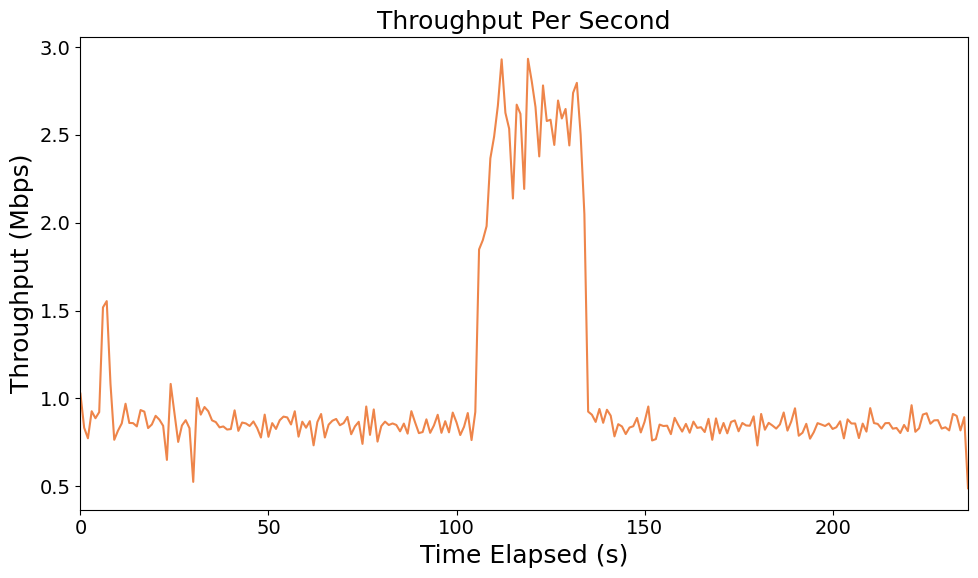

In [6]:
interval = 1000
throughputs = []
starts = [x[0] + timedelta(milliseconds=i) for i in range(0, int((x[-1] - x[0]).total_seconds()*1000), interval)]
for t in starts:
    start_time = t
    end_time = t + timedelta(milliseconds=interval)
    bytes_in_interval = sum([length for timestamp, length in zip(x, y) if start_time <= timestamp < end_time])
    throughput_bps = bytes_in_interval / interval
    throughputs.append(throughput_bps)

fig, ax = plt.subplots()
elapsed = [(e - starts[0]).total_seconds() for e in starts]

ax.plot(elapsed, np.array(throughputs) / 1000 * 8, color=orange, linewidth=1.5)
ax.set_title("Throughput Per Second")
ax.set_xlabel("Time Elapsed (s)")
ax.set_ylabel("Throughput (Mbps)")

plt.xlim(0, elapsed[-1])
plt.tight_layout()
plt.show()

In [7]:
interval = 10
bursts = []
starts = [x[0] + timedelta(milliseconds=i) for i in range(0, int((x[-1] - x[0]).total_seconds() * 1000), interval)]

for t in starts:
    start_time = t
    end_time = t + timedelta(milliseconds=interval)
    bytes_in_interval = sum([length for timestamp, length in zip(x, y) if start_time <= timestamp < end_time])
    bursts.append(bytes_in_interval)
    
num_bins = len(bursts)
buckets = np.arange(num_bins)
bin_edges = np.arange(num_bins + 1)

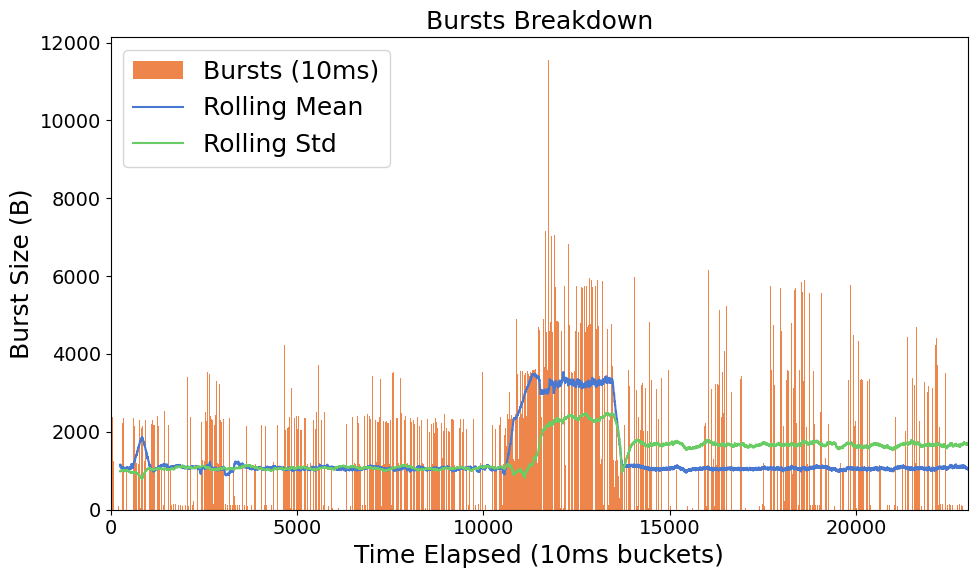

In [8]:
df = pd.DataFrame({'Bursts': bursts}, index=np.arange(num_bins))

window_size = 250
rolling_mean = df['Bursts'].rolling(window=window_size).mean()
rolling_std = df['Bursts'].rolling(window=window_size).std()

fig, ax = plt.subplots()
ax.hist(buckets, bins=bin_edges, weights=bursts, label='Bursts (10ms)', align='left', color=orange)
plt.plot(rolling_mean.index, rolling_mean, color=blue, label='Rolling Mean')
plt.plot(rolling_std.index, rolling_std, color=green, label='Rolling Std')
ax.set_title("Bursts Breakdown")
ax.set_xlabel("Time Elapsed (10ms buckets)")
ax.set_ylabel("Burst Size (B)")
plt.legend()

plt.xlim(0, 23000)
plt.tight_layout()
plt.show()

In [9]:
latencies = []

for i in range(len(x) - 1):
    time_difference = (x[i + 1] - x[i]).total_seconds()*1000
    latencies.append(time_difference)

elapsed = [(e - x[0]).total_seconds() for e in x]

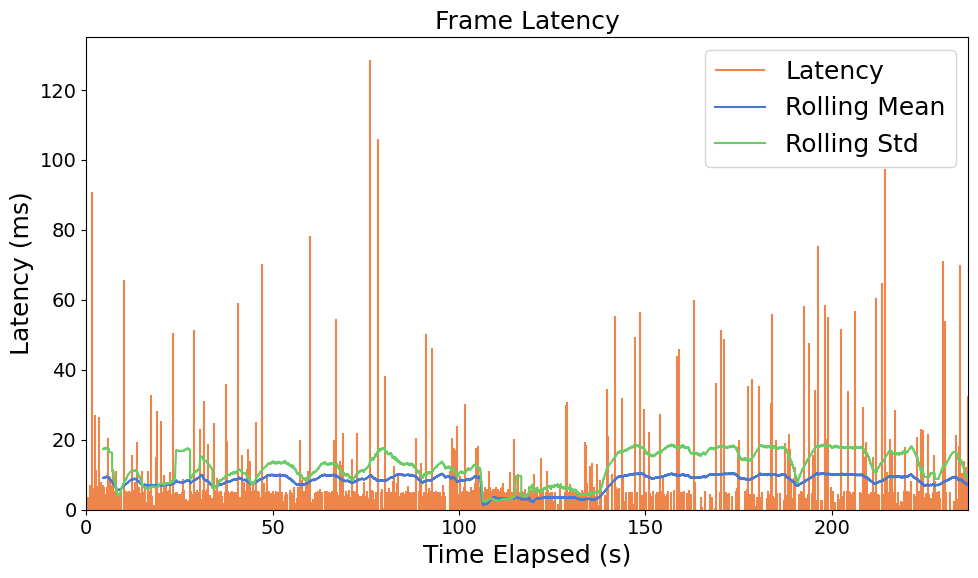

In [10]:
df = pd.DataFrame({'Latency': latencies}, index=elapsed[1:])
window_size = 500
rolling_mean = df['Latency'].rolling(window=window_size).mean()
rolling_std = df['Latency'].rolling(window=window_size).std()

fig, ax = plt.subplots()
plt.vlines(elapsed[1:][::33], ymin=0, ymax=latencies[::33], color=orange, label="Latency")
plt.plot(elapsed[1:], rolling_mean, color=blue, label='Rolling Mean')
plt.plot(elapsed[1:], rolling_std, color=green, label='Rolling Std')

plt.title("Frame Latency")

plt.xlabel("Time Elapsed (s)")
plt.ylabel("Latency (ms)")
plt.legend()

plt.xlim(0, elapsed[-1])
plt.ylim(0)
plt.tight_layout()
plt.show()